Author: Tyler Chase

Date: 2017/05/18

# Subreddit Multitask Classification

This code uses a multitask AlexNet model to classify a subreddit origin of an image, as well as whether an image is safe for work (sfw) or not safe for work (nsfw). 

## Load Datasets

In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import random
import pickle
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from util import import_dataset, sample_data, plot_confusion_matrix
from multiclass_model import MulticlassModel, lazy_property
from config import ModelConfig, TrainConfig
from data_stats import DataStats
%matplotlib inline

# Set default to auto import packages
%load_ext autoreload
%autoreload 2

In [2]:
# Form training, developement, and testing data sets
address = r'/home/tylerchase/CS-231N-Final-Project/data/fullData//'
address = r'../../data/fullData//'
file_names = {}
file_names['images'] = 'full_data.npy'
file_names['subs'] = 'full_subredditlabels'
file_names['dict'] = 'full_subredditIndex'
file_names['nsfw'] = 'full_nsfwlabels'
data, dictionary = import_dataset(address, file_names)

# Print the sizes as a sanity check
print('Train data shape: ', data.X_train.shape)
print('Train subreddit labels shape: ', data.y_train.shape)
print('Train nsfw labels shape: ', data.y_train_2.shape)
print('Validation data shape: ', data.X_val.shape)
print('Validation subreddit labels shape: ', data.y_val.shape)
print('Validation nsfw labels shape: ', data.y_val_2.shape)
print('Test data shape: ', data.X_test.shape)
print('Test subreddit labels shape: ', data.y_test.shape)
print('Test nsfw labels shape: ', data.y_test_2.shape)

Train data shape:  (25450, 128, 128, 3)
Train subreddit labels shape:  (25450,)
Train nsfw labels shape:  (25450,)
Validation data shape:  (3181, 128, 128, 3)
Validation subreddit labels shape:  (3181,)
Validation nsfw labels shape:  (3181,)
Test data shape:  (3182, 128, 128, 3)
Test subreddit labels shape:  (3182,)
Test nsfw labels shape:  (3182,)


## Optional Cell to take Particular Subreddits from Dataset

In [ ]:
subreddits = ['gonewild', 'ladybonersgw', 'PrettyGirls', 'LadyBoners']
dictionary = sample_data(subreddits, data, dictionary)

## Define AlexNet model 

* 11x11 convolutional layer with 96 filters and a stride of 4
* ReLU activation
* 3x3 max pooling with a stride of 2
* batch normalization


* 5x5 convolutional layer with 256 filters and a stride of 1
* ReLU activation
* 3x3 max pooling with a stride of 2
* batch normalization


* 3x3 convolutional layer with 384 filters and a stride of 1
* ReLU activation
* 3x3 convolutional layer with 384 filters and a stride of 1
* ReLU activation 
* 3x3 convolutional layer with 256 filters and a stride of 1
* ReLU activation
* 3x3 max pooling with a stride of 2

First path
* affine layer from 4096 to 4096          
* ReLU activation                          
* affine layer from 4096 to 4096
* ReLU activation
* affine layer from 4096 to 20

Second path
* affine layer from 4096 to 4096          
* ReLU activation                          
* affine layer from 4096 to 4096
* ReLU activation
* affine layer from 4096 to 2

In [4]:
class AlexNet(MulticlassModel):
    
    def __init__(self, model_config):
        MulticlassModel.__init__(self, model_config)
  
    @lazy_property
    def prediction(self):
        # define our graph (e.g. AlexNet)
        
        a1 = tf.layers.conv2d(self.X_placeholder, filters=96, kernel_size=(11,11), strides=(4,4), padding='SAME') 
        h1 = tf.nn.relu(a1)
        mp1 = tf.layers.max_pooling2d(h1, pool_size=(3,3), strides=(2,2), padding='SAME')    
        bn1 = tf.layers.batch_normalization(mp1, training=self.is_training_placeholder)
        
        a2 = tf.layers.conv2d(bn1, filters=256, kernel_size=(5,5), strides=(1,1), padding='SAME')     
        h2 = tf.nn.relu(a2)
        mp2 = tf.layers.max_pooling2d(h2, pool_size=(3,3), strides=(2,2), padding='SAME')    
        bn2 = tf.layers.batch_normalization(mp2, training=self.is_training_placeholder)              
    
        a3 = tf.layers.conv2d(bn2, filters=384, kernel_size=(3,3), strides=(1,1), padding='SAME')    
        h3 = tf.nn.relu(a3)
        a4 = tf.layers.conv2d(h3, filters=384, kernel_size=(3,3), strides=(1,1), padding='SAME')   
        h4 = tf.nn.relu(a4)
        a5 = tf.layers.conv2d(h4, filters=256, kernel_size=(3,3), strides=(1,1), padding='SAME')    
        h5 = tf.nn.relu(a5)
        mp3 = tf.layers.max_pooling2d(h5, pool_size=(3,3), strides=(2,2), padding='SAME')  
    
        mp_flat = tf.reshape(mp3,[-1,4096])
        
        # First path for subreddit
        aff1 = tf.layers.dense(mp_flat, 4096)
        h6 = tf.nn.relu(aff1)
        aff2 = tf.layers.dense(h6, 4096)
        h7 = tf.nn.relu(aff2)
        y_out = tf.layers.dense(h7, self.config.subreddit_class_size)
        
        # First path for nsfw
        aff1_2 = tf.layers.dense(mp_flat, 4096)
        h6_2 = tf.nn.relu(aff1_2)
        aff2_2 = tf.layers.dense(h6_2, 4096)
        h7_2 = tf.nn.relu(aff2_2)
        y_out_2 = tf.layers.dense(h7_2, self.config.nsfw_class_size)
    
        return y_out, y_out_2

## Train the Model

In [ ]:
# Create model instance
tf.reset_default_graph()

model_config = ModelConfig(learning_rate=0.003, sbrd_weight=0.80)
train_config = TrainConfig(num_epochs=20, train_batch_size=100, print_every=100, \
    saver_address=r'../../subreddit_classification_parameters/', \
    save_file_name = 'AlexNet_multitask_classification')
model = AlexNet(model_config)

# Create session
session = tf.Session()
model.train(data, session, train_config)

## Return Loss and Accuracy History

In [ ]:
# Plot Loss and Accuracy
model.plot_loss_acc(data)

## Hyperparameter Search

In [ ]:
model_config = ModelConfig(learning_rate=0.003, sbrd_weight=0.80)
train_config = TrainConfig(num_epochs=15, 
                    train_batch_size=64, 
                    print_every=1000)
modelHP = ResNet(model_config)
session = tf.Session()

def objective(args):

    tf.reset_default_graph()
    modelHP = ResNet(model_config)
    session = tf.Session()
    
    #train_config.num_epochs = args['Nepochs']
    train_config.lr_decay = args['decayRate']
    modelHP.config.learning_rate = args['learningRate']
    modelHP.config.sbrd_weight = args['costWeight']
    
    modelHP.train(data, session, train_config)
    cost, accuracy_sbrd, accuracy_nsfw = modelHP.eval(data, session, "val")
    
    saveList = {
        'accuracy_sbrd' : accuracy_sbrd,
        'accuracy_nsfw' : accuracy_nsfw,
        'cost' : cost,
        #'Nepochs' : args['Nepochs'],
        'learningRate' : args['learningRate'],
        'decayRate' : args['decayRate'],
        'costWeight' : args['costWeight']
    }    
    pickle.dump(saveList, open("../../hprOpt/hprPrmOpt_" + str(accuracy_sbrd) + "_"  + str(accuracy_nsfw) + "_" + str(cost) + ".dat", "wb"))
    
    return cost

def optimize():
    
    space = {
        #'Nepochs' : hpropt.hp.randint('Nepochs', 70),
        'learningRate' : hpropt.hp.loguniform('learningRate', -4, -1),
        'decayRate' : hpropt.hp.uniform('decayRate', 0.9, 1),
        'costWeight' : hpropt.hp.uniform('costWeight', 0.5, 1)
    }
    
    best = hpropt.fmin(objective, space, algo=hpropt.tpe.suggest, max_evals=10)
    print(best)
    
    return best

In [ ]:
optimize()

## Test Loading the Model

In [5]:
# Reset Graph
tf.reset_default_graph()

# Create model instance
model_config = ModelConfig(learning_rate=0.003, sbrd_weight=0.80)
train_config = TrainConfig(num_epochs=20, train_batch_size=100, print_every=10, \
    saver_address=r'../../subreddit_classification_parameters/', \
    save_file_name = 'AlexNet_multitask_classification')
model = AlexNet(model_config)

# Load Saved Model
session = tf.Session()
saver = tf.train.Saver()
saver.restore(session, train_config.saver_address + train_config.save_file_name) 

# Test Model Accuracy
loss_train, acc_train_sub, acc_train_nsfw = model.eval(data, session, split='train')
loss_val, acc_val_sub, acc_val_nsfw = model.eval(data, session, split = 'val')

subreddit train accuracy:50.2%
nsfw train accuracy:94.5%
subreddit val accuracy:44.5%
nsfw val accuracy:93.7%


## Output Predictions for Validation 

In [6]:
y_val_pred_sub, y_val_pred_nsfw = session.run(model.prediction, {model.X_placeholder: data.X_val, \
    model.y_sbrd_placeholder: data.y_val, model.y_nsfw_placeholder: data.y_val_2, \
    model.is_training_placeholder:False})

y_val_pred_sub = np.argmax(y_val_pred_sub, axis = 1)
y_val_pred_nsfw = np.argmax(y_val_pred_nsfw, axis = 1)

## Plot Confusion Matrix for Subreddit Classification

Normalized confusion matrix


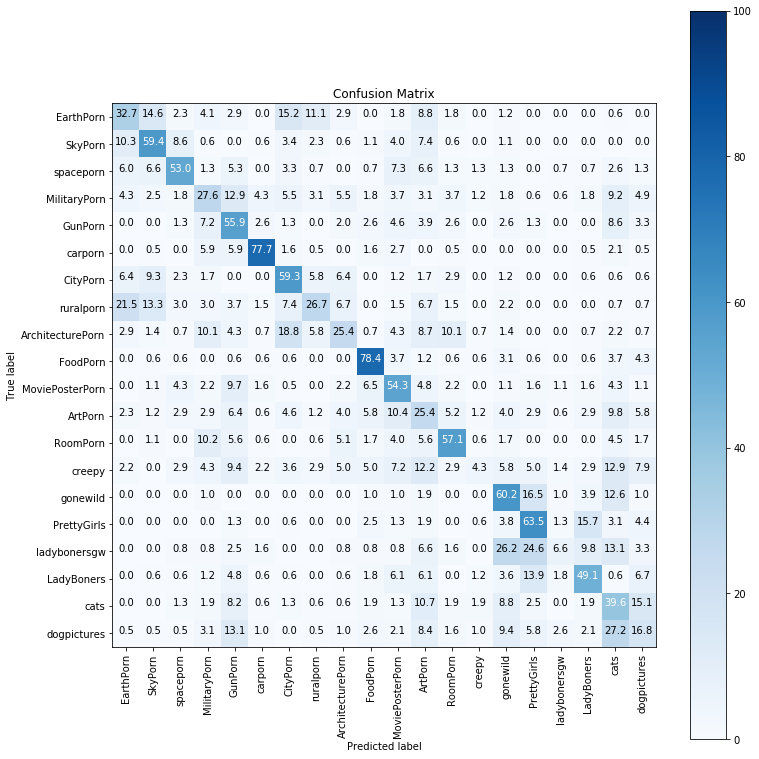

In [8]:
classes = [""] * len(dictionary)
for sub, ind in dictionary.items():
    classes[ind] = sub

conf = confusion_matrix(data.y_val, y_val_pred_sub)
plot_confusion_matrix(conf, classes=classes, normalize = True)

## Plot Confusion Matrix for NSFW Classification

Normalized confusion matrix


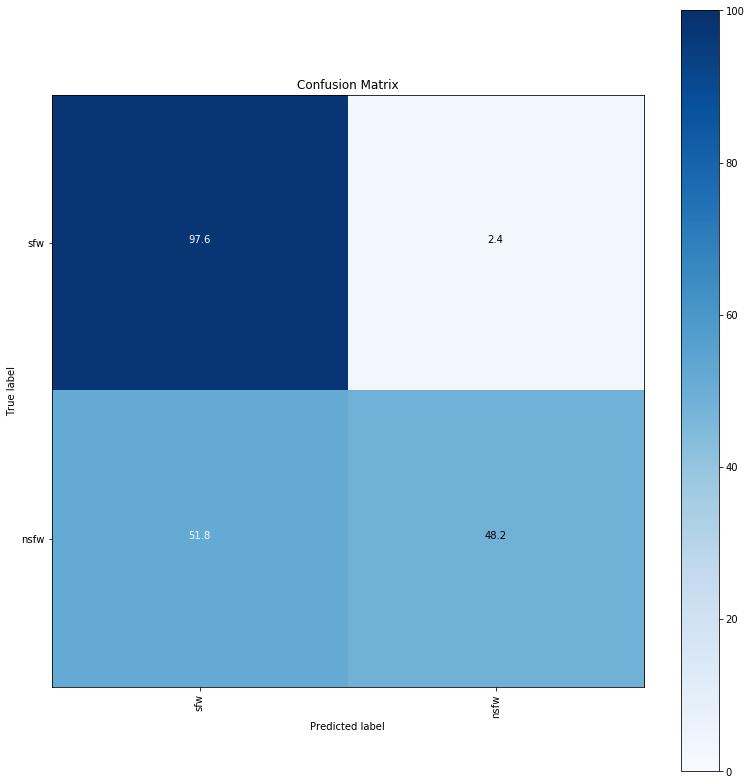

In [9]:
classes = ['sfw', 'nsfw']

conf = confusion_matrix(data.y_val_2, y_val_pred_nsfw)
plot_confusion_matrix(conf, classes=classes, normalize = True)

In [8]:
data_stats = DataStats(data, dictionary)
data_stats.nsfw_stats(dataSet = 'val')

NSFW Submissions:  255
SFW Submissions:  2926
Sanity Check Sum:  3181

Total Submissions:  3181
